In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# Jax imports
import equinox as eqx
import jax
import jax.numpy as jnp
import numpy as np
from jax import config

config.update("jax_enable_x64", False)

In [3]:
# for sampling random rotations
from scipy.spatial.transform import Rotation


In [4]:
# Plotting imports and function definitions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [28]:
# Image simulator imports
import cryojax.simulator as cs
from cryojax.utils import fftn, ifftn, irfftn, make_frequencies
from cryojax.reconstruct import backproject

In [12]:
# Volume filename and metadata
filename = "../tests/data/3jar_13pf_bfm1_ps5_28.mrc"

In [6]:
# Read template into either an ElectronCloud or ElectronGrid
resolution = 5.28  # Angstroms
#density = cs.VoxelCloud.from_file(filename, config=dict(atol=1e-8))
density = cs.VoxelGrid.from_file(filename, config=dict(pad_scale=1.5))
pose = cs.EulerPose(offset_x=-50.0, offset_y=20.0, view_phi=-20, view_theta=100, view_psi=20)
specimen = cs.Specimen(density=density, pose=pose, resolution=resolution)

2024-01-05 11:43:35.343175: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.103). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


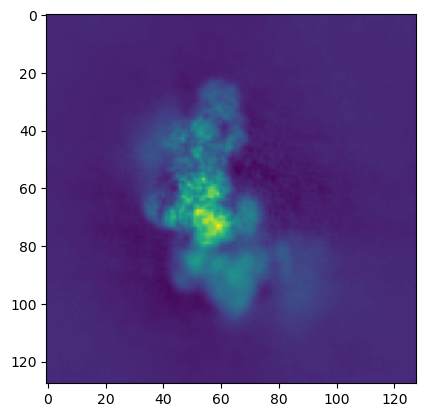

In [73]:
# gt_vol_r = ifftn(density.weights).real

# plt.imshow(gt_vol_r.sum(0))

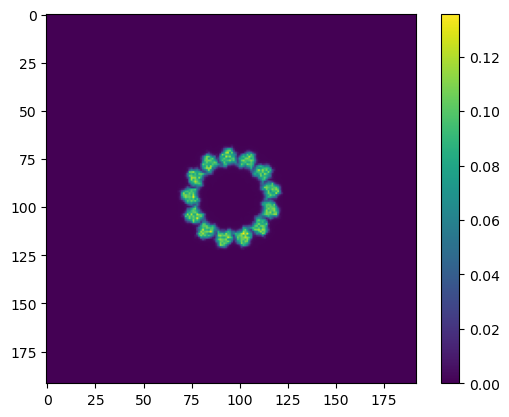

In [7]:
N = len(density.weights)
slice_f = jnp.fft.fftshift(density.weights)[:,:,N//2]
slice = irfftn(jnp.fft.ifftshift(slice_f))
plt.imshow(slice)
plt.colorbar()


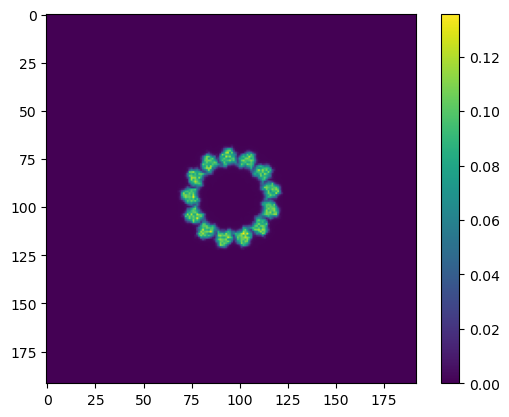

In [8]:
N = len(density.weights)
density_r = irfftn(density.weights)
slice = density_r.sum(-1)
plt.imshow(slice)
plt.colorbar()

# insert slice when on grid

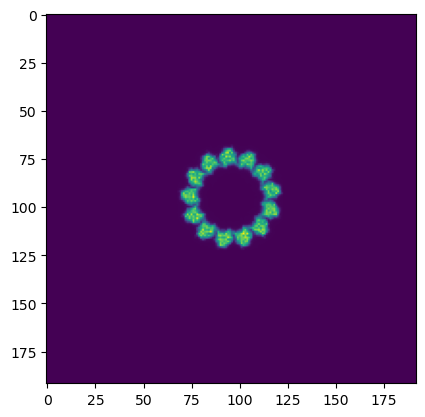

In [9]:
density_centred = jnp.fft.fftshift(density.weights)
central_slice = density_centred[:,:,N//2]

empty_f_volume = jnp.zeros_like(density.weights)
empty_f_volume = empty_f_volume.at[:,:,N//2].set(central_slice)
empty_volume = irfftn(jnp.fft.ifftshift(empty_f_volume))

plt.imshow(empty_volume.sum(-1))

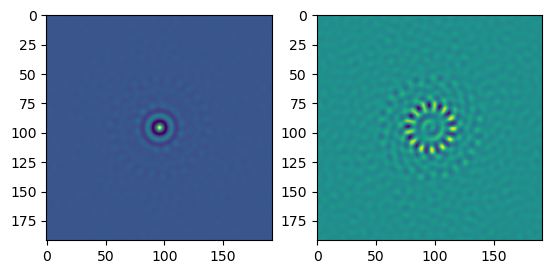

In [10]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(central_slice.real)
axes[1].imshow(central_slice.imag)

# insert slice when on grid, with interpolation code

In [11]:
from cryojax.utils import interpolate

n_pix = N

def insert_slice_and_interpolate(slice_real, xyz_rotated_single, n_pix):
    r0, r1, dd = interpolate.diff(xyz_rotated_single)
    map_3d_interp_slice, count_3d_interp_slice = interpolate.interp_vec(
        slice_real, r0, r1, dd, n_pix
    )
    inserted_slice_3d = map_3d_interp_slice.reshape((n_pix, n_pix, n_pix))
    count_3d = count_3d_interp_slice.reshape((n_pix, n_pix, n_pix))
    return inserted_slice_3d, count_3d



### in plane
* there are 13 fibres making the cylindar. we rotate by 360/13/2 deg so show half a fiber rotation, which stands out visually.

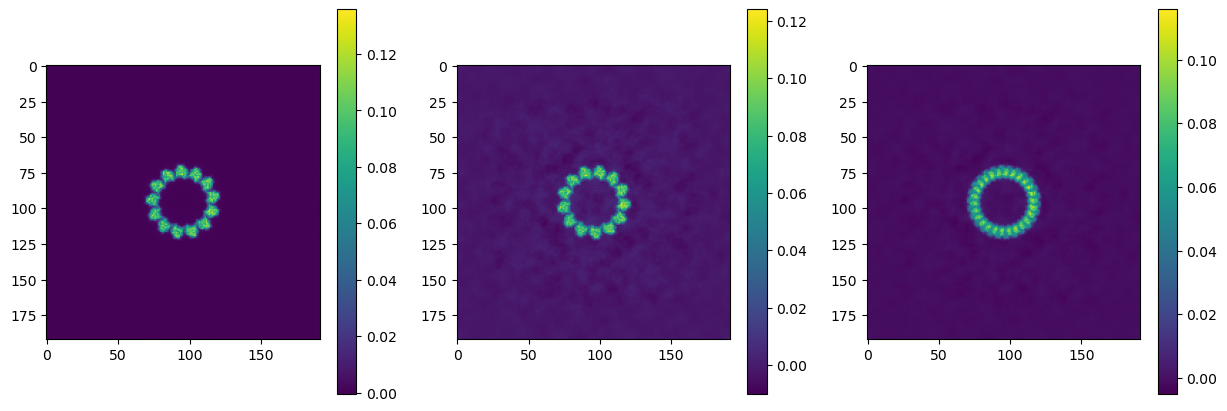

In [12]:
from cryojax.utils import make_coordinates

fig, axes = plt.subplots(1,3, figsize=(15,5))


inserted_slice_3d_r_both = np.zeros((n_pix,n_pix,n_pix,2))
for idx, view_phi in enumerate([0, 360/13/2]):

    xyz = jnp.zeros((3,N**2))
    rotation = cs.EulerPose(view_phi=view_phi).rotation.as_matrix()
    xyz_rotated_single = xyz.at[:2].set(rotation[:2,:2] @ make_coordinates((N,N)).reshape(-1,2).T)

    inserted_slice_3d_real, count_3d_real = insert_slice_and_interpolate(central_slice.real, xyz_rotated_single, n_pix)
    inserted_slice_3d_imag, count_3d_imag = insert_slice_and_interpolate(central_slice.imag, xyz_rotated_single, n_pix)

    inserted_slice_3d_f = inserted_slice_3d_real*count_3d_real + 1j*inserted_slice_3d_imag*count_3d_imag

    inserted_slice_3d_r = irfftn(jnp.fft.ifftshift(inserted_slice_3d_f))
    inserted_slice_3d_r_both[:,:,:,idx] = inserted_slice_3d_r
    
    im = axes[idx].imshow(inserted_slice_3d_r.sum(-1))
    fig.colorbar(im, ax=axes[idx])

idx += 1
im = axes[idx].imshow(inserted_slice_3d_r_both.sum(-2).mean(-1))
fig.colorbar(im, ax=axes[idx])



### arbitraty rotation


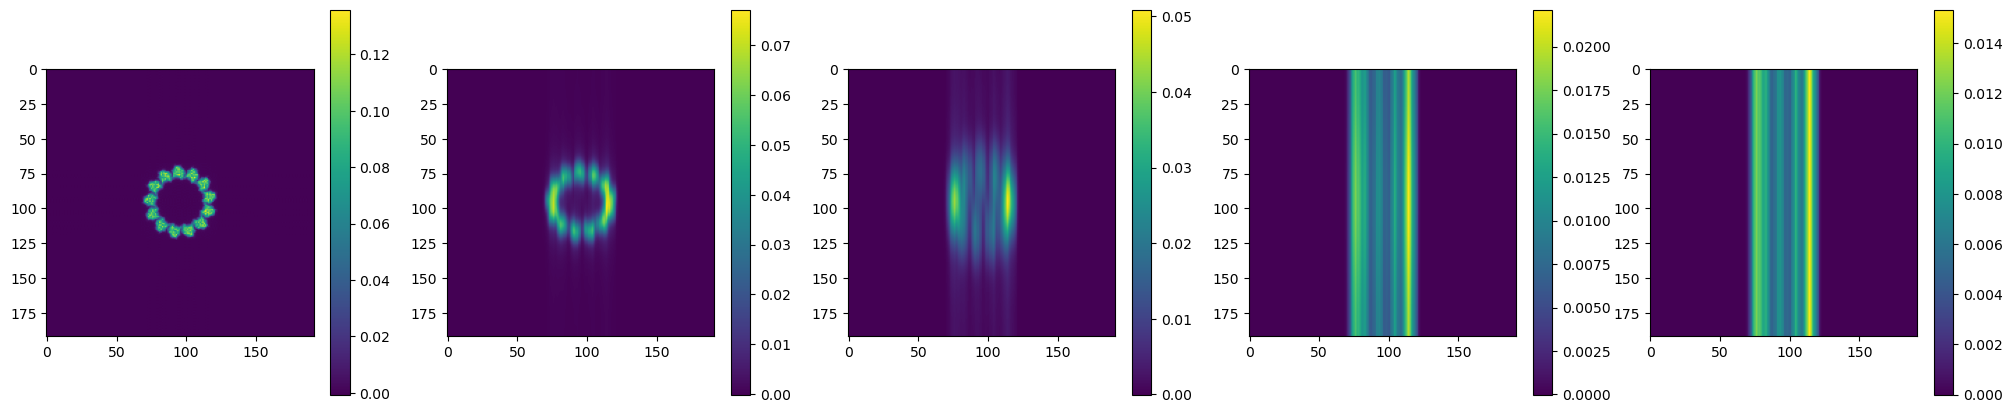

In [13]:

from cryojax.utils import make_coordinates

angles_deg = [0, 3, 10, 45, 90]
fig, axes = plt.subplots(1,len(angles_deg), figsize=(5*len(angles_deg),5))


# inserted_slice_3d_r_both = np.zeros((n_pix,n_pix,n_pix,2))

for idx, view_theta in enumerate(angles_deg):

    xyz = jnp.zeros((3,N**2))
    rotation = cs.EulerPose(view_theta=view_theta).rotation.as_matrix()
    xyz_rotated_single = rotation @ xyz.at[:2].set(make_coordinates((N,N)).reshape(-1,2).T)

    inserted_slice_3d_real, count_3d_real = insert_slice_and_interpolate(central_slice.real, xyz_rotated_single, n_pix)
    inserted_slice_3d_imag, count_3d_imag = insert_slice_and_interpolate(central_slice.imag, xyz_rotated_single, n_pix)

    inserted_slice_3d_f = inserted_slice_3d_real*count_3d_real + 1j*inserted_slice_3d_imag*count_3d_imag

    inserted_slice_3d_r = irfftn(jnp.fft.ifftshift(inserted_slice_3d_f))
    # inserted_slice_3d_r_both[:,:,:,idx] = inserted_slice_3d_r
    
    im = axes[idx].imshow(inserted_slice_3d_r.sum(-1))
    fig.colorbar(im, ax=axes[idx])

# idx += 1
# im = axes[idx].imshow(inserted_slice_3d_r_both.sum(-2).mean(-1))
# fig.colorbar(im, ax=axes[idx])



# method in `cryojax.simulator.scattering._fourier_slice`

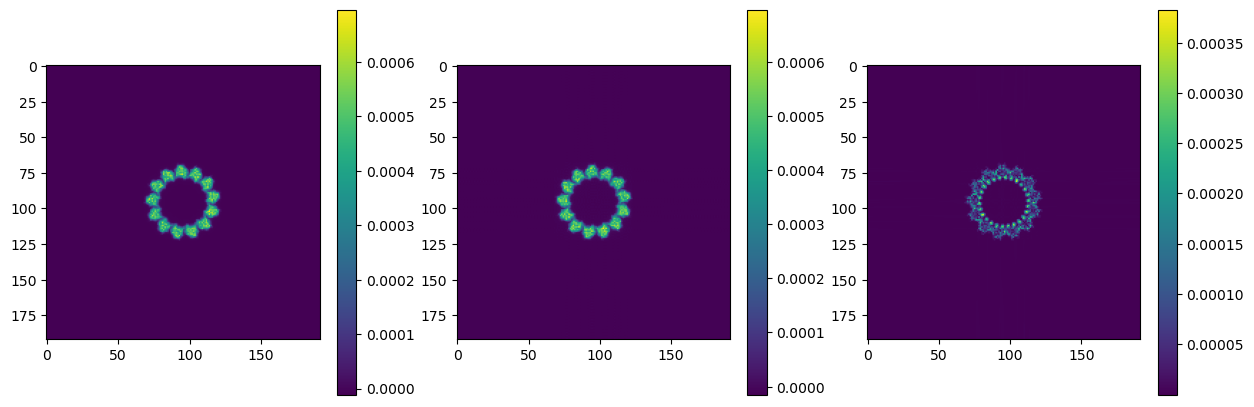

In [44]:
resolution = 5.28  # Angstroms
density = cs.VoxelGrid.from_file(filename, config=dict(pad_scale=1.5))
pose = cs.EulerPose(view_phi=0, view_theta=0, view_psi=0)
specimen = cs.Specimen(density=density, pose=pose, resolution=resolution)

shape=density.weights.shape[:2]
pad_scale = 1
scattering = cs.FourierSliceScattering(shape=shape, pad_scale=pad_scale)
scattering_model = cs.ImagePipeline(scattering=scattering, specimen=specimen)
image = scattering_model.render()


fig, axes = plt.subplots(1,3, figsize=(15,5))
im = axes[0].imshow(image)
fig.colorbar(im, ax=axes[0])


slice_f = jnp.fft.fftshift(fftn(image))
volume = insert_slice(slice_f, pose, to_real=True)
im = axes[1].imshow(volume.sum(-1))
fig.colorbar(im, ax=axes[1])


im = axes[2].imshow(jnp.abs(volume.sum(-1) - image))
fig.colorbar(im, ax=axes[2])


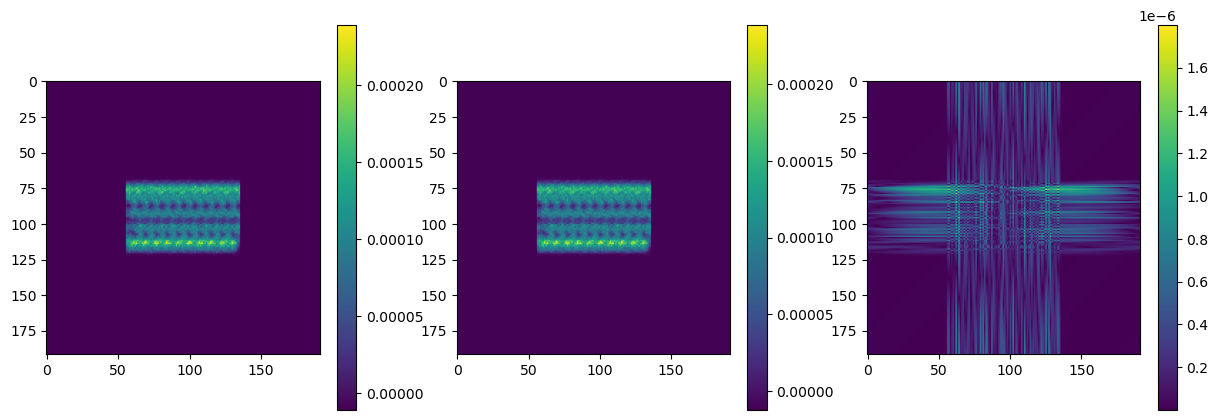

In [45]:
resolution = 5.28  # Angstroms
density = cs.VoxelGrid.from_file(filename, config=dict(pad_scale=1.5))
pose = cs.EulerPose(view_phi=0, view_theta=-90, view_psi=0)
specimen = cs.Specimen(density=density, pose=pose, resolution=resolution)

shape=density.weights.shape[:2]
pad_scale = 1
scattering = cs.FourierSliceScattering(shape=shape, pad_scale=pad_scale)
scattering_model = cs.ImagePipeline(scattering=scattering, specimen=specimen)
image = scattering_model.render()


fig, axes = plt.subplots(1,3, figsize=(15,5))
im = axes[0].imshow(image)
fig.colorbar(im, ax=axes[0])


slice_f = jnp.fft.fftshift(fftn(image))
volume = insert_slice(slice_f, pose, to_real=True)
im = axes[1].imshow(volume.sum(0))
fig.colorbar(im, ax=axes[1])


im = axes[2].imshow(jnp.abs(volume.sum(0) - image))
fig.colorbar(im, ax=axes[2])

# filtered-back-projection: reconstruct by inserting many slices
* see Chapter 12.5 "Reconstruction from Projections by Filtered Back Projection" in Hobbie, R. K., & Roth, B. J. (2007). Intermediate Physics for Medicine and Biology (4th ed.). New York, NY: Springer New York. http://doi.org/10.1007/978-0-387-49885-0

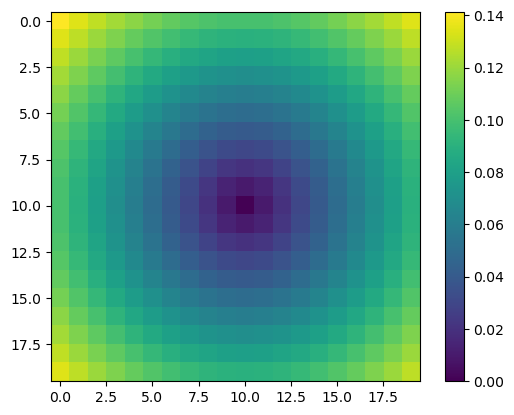

In [14]:
n_pix_render = 100

freq_xy = make_frequencies((n_pix_render,n_pix_render), half_space=False)
freq_abs = jnp.hypot(freq_xy[:,:,0],freq_xy[:,:,1])
freq_abs = jnp.fft.fftshift(freq_abs)

plt.imshow(freq_abs[n_pix_render//2-10:n_pix_render//2+10,n_pix_render//2-10:n_pix_render//2+10])
plt.colorbar()

In [61]:
n_slices = 100
filename = "../hackathon/emd-3683.mrc"
random_rotations = Rotation.random(n_slices).as_euler('zyz', degrees=True) # np.random.uniform(-180,180, size=(n_slices,3))
random_df = np.random.uniform(800,1000, size=n_slices)

resolution = 1  # Angstroms
density = cs.VoxelGrid.from_file(filename, config=dict(pad_scale=1, crop_scale=1))
shape=density.weights.shape[:2]
pad_scale = 1
pixel_size = 1

n_pix_render = shape[0]
manager = cs.ImageManager(shape=shape, pad_scale=pad_scale)
scattering = cs.FourierSliceExtract(manager, pixel_size=pixel_size)
exposure = cs.UniformExposure(N=1.0, mu=0.0)
detector = cs.GaussianDetector(variance=cs.Constant(30.0))

volume_sum_f = jnp.zeros((n_pix_render,n_pix_render,n_pix_render), dtype=jnp.complex64)

freq_xy = jnp.fft.fftshift(make_frequencies((n_pix_render,n_pix_render), half_space=False))
freq_abs = jnp.hypot(freq_xy[:,:,0],freq_xy[:,:,1])
slices_f = jnp.zeros((n_slices, n_pix_render,n_pix_render), dtype=jnp.complex64)
poses = []

for idx in range(n_slices):
    pose = cs.EulerPose(view_phi=random_rotations[idx,0], view_theta=random_rotations[idx,1], view_psi=random_rotations[idx,2])
    poses.append(pose)
    ensemble = cs.Ensemble(density=density, pose=pose)
    df = random_df[idx]
    optics = cs.CTFOptics(defocus_u=df, defocus_v=df, amplitude_contrast=.07)
    instrument_od = cs.Instrument(exposure=exposure, optics=optics, detector=detector)
    pipeline = cs.ImagePipeline(scattering=scattering, instrument=instrument_od, ensemble=ensemble)
    key = jax.random.PRNGKey(idx)
    image = pipeline.sample(key)
    image_f = jnp.fft.fftshift(fftn(image))

    ctf = optics(freq_xy)
    wiener_filter = backproject.WeinerFilter(ctf, 0.0001)
    image_deconv = wiener_filter(image_f)
    
    slices_f = slices_f.at[idx].set(image_deconv)
    slice_f_ram_lak_filtered = freq_abs * image_deconv
    volume_f = backproject.insert_slice(slice_f_ram_lak_filtered, pose, to_real=False)
    volume_sum_f += volume_f

volume_r = ifftn(jnp.fft.ifftshift(volume_sum_f/n_slices)).real * jnp.sqrt(n_pix_render**3)


### in `reconstruct.backproject`

In [65]:
from cryojax.reconstruct import backproject

deconvolved_images = slices_f

fbp_vol_r = backproject.filtered_backprojection(deconvolved_images, poses)


In [67]:
fbp_vol_f = backproject.filtered_backprojection(deconvolved_images, poses, to_real = True)

In [64]:
np.allclose(fbp_vol_r, volume_r)

True

### fori loop

In [17]:
init_value = 0
start = 0
stop = 10
vals = jnp.arange(start, stop)
powers = jnp.ones(stop)
def body_fun(i, init_value):
    val = vals[i]
    power = powers[i]
    return init_value + val**power + 100
jax.lax.fori_loop(start, stop, body_fun, init_value) 

Array(45., dtype=float32)

In [25]:

def accumulate_insert_slice(slice_idx, volume_sum_f):
    slice_f = slices_f[slice_idx]
    pose = cs.EulerPose(view_phi=random_rotations[idx,0], view_theta=random_rotations[idx,1], view_psi=random_rotations[idx,2])
    slice_f_ram_lak_filtered = freq_abs * slice_f
    volume_f = insert_slice(slice_f_ram_lak_filtered, pose, to_real=False)
    volume_sum_f += volume_f
    return volume_sum_f

volume_sum_f = jax.lax.fori_loop(0, n_slices,
                                 accumulate_insert_slice, 
                                 jnp.zeros((n_pix_render,n_pix_render,n_pix_render), dtype=jnp.complex64)
                                 )

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on traced array with shape float32[3,16384].
The error occurred while tracing the function scanned_fun at /mnt/home/gwoollard/software/mambaforge/envs/cryojax/lib/python3.10/site-packages/jax/_src/lax/control_flow/loops.py:1853 for scan. This value became a tracer due to JAX operations on these lines:

  operation a:f32[] = convert_element_type[new_dtype=float32 weak_type=False] b
    from line /mnt/home/gwoollard/repos/cryojax/src/cryojax/core.py:49 (<lambda>)

  operation a:f32[] = convert_element_type[new_dtype=float32 weak_type=False] b
    from line /mnt/home/gwoollard/repos/cryojax/src/cryojax/core.py:49 (<lambda>)

  operation a:f32[] = convert_element_type[new_dtype=float32 weak_type=False] b
    from line /mnt/home/gwoollard/repos/cryojax/src/cryojax/core.py:49 (<lambda>)

  operation a:f32[] = convert_element_type[new_dtype=float32 weak_type=False] b
    from line /mnt/home/gwoollard/repos/cryojax/src/cryojax/simulator/scattering/_fourier_slice.py:156 (insert_slice)

  operation a:f32[] = mul b c
    from line /mnt/home/gwoollard/repos/cryojax/src/cryojax/simulator/pose.py:274 (make_euler_rotation)

(Additional originating lines are not shown.)
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

### plot

Text(0.5, 0.98, 'n_slices = 100 \n Ram-Lak filtered')

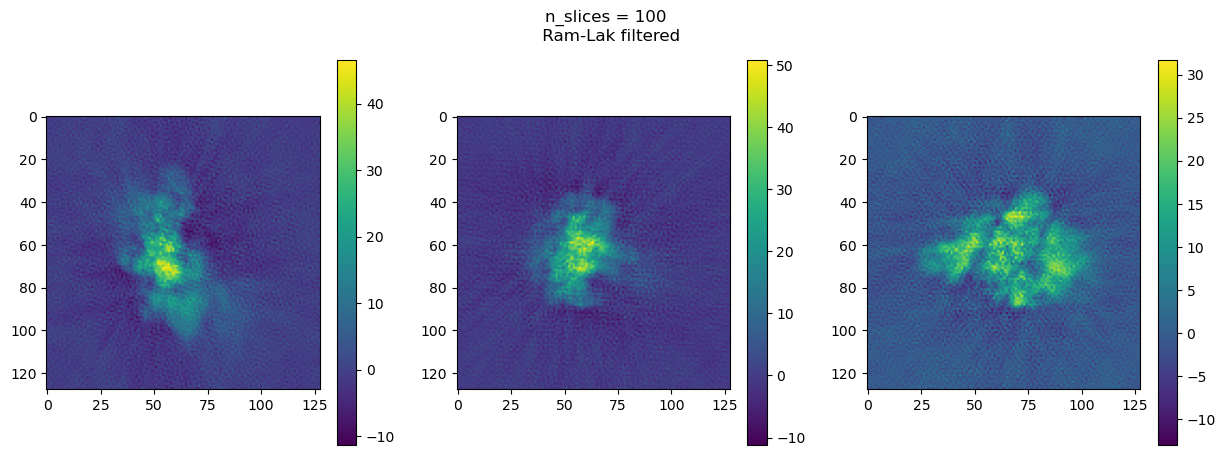

In [59]:
fig, axes = plt.subplots(1,3, figsize=(15,5))

im = axes[0].imshow(volume_r.sum(0))
fig.colorbar(im, ax=axes[0])

im = axes[1].imshow(volume_r.sum(1))
fig.colorbar(im, ax=axes[1])

im = axes[2].imshow(volume_r.sum(2))
fig.colorbar(im, ax=axes[2])

fig.suptitle('n_slices = {} \n Ram-Lak filtered'.format(n_slices))

Text(0.5, 0.98, 'perfect reconstruction (summing real-space volume)')

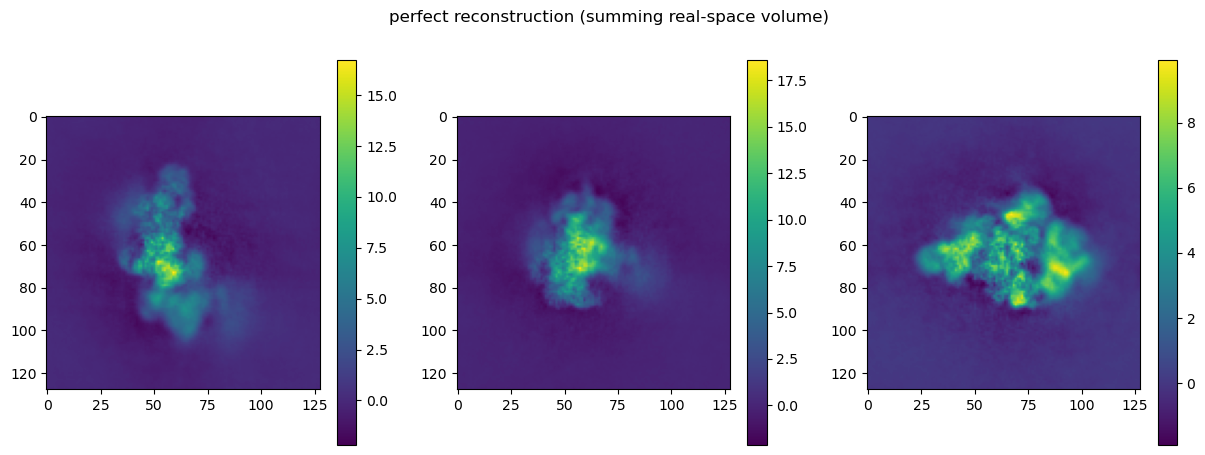

In [204]:
fig, axes = plt.subplots(1,3, figsize=(15,5))

density = cs.VoxelGrid.from_file(filename, config=dict(pad_scale=1, crop_scale=1))

n_full = len(density.weights)

volume_theoretical = irfftn(density.weights)#[n_full//2-32//2:n_full//2+32//2,n_full//2-32//2:n_full//2+32//2,n_full//2-32//2:n_full//2+32//2]

im = axes[0].imshow(volume_theoretical.sum(0))
fig.colorbar(im, ax=axes[0])

im = axes[1].imshow(volume_theoretical.sum(1))
fig.colorbar(im, ax=axes[1])

im = axes[2].imshow(volume_theoretical.sum(2))
fig.colorbar(im, ax=axes[2])

fig.suptitle('perfect reconstruction (summing real-space volume)')



## simple phantom shape (sphere, cube)



In [ ]:
n_pix = 16
coords = make_coordinates((n_pix,n_pix,n_pix))
jnp.hypot(coords[:,:,0])